In [1]:
import numpy as np
import sys
sys.path.append('/home/jiayun/Desktop/oa-workspace/Exercises/')
sys.path.append('..')
from sigmoid_activation import activation
from sklearn.preprocessing import PolynomialFeatures
from regression_utils import read_residual_data, build_dataset_RR
import matplotlib.pyplot as plt
import matplotlib
from regression import BoostRegressor
from regression import CV_RR
from sigmoid_activation import Sigmoid
from Common.Dataset_generator import Datasets, DatasetsNMResidualBlockToOne
from Common.utils import friction_dof
dof = 7
varphi = [10, 3.93, 1e-8] # from grid search
fric_param = np.load('../Common/fric_param.npy')

matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

In [2]:
def feature(X):
    aug = X
    for k in range(1,26):
        aug = np.concatenate([aug, np.sin(k * np.pi * X)], axis=1)
        aug = np.concatenate([aug, np.cos(k * np.pi * X)], axis=1)
    poly = PolynomialFeatures(1)
    X = poly.fit_transform(aug)
    return X

def feature_sig(x):
    aug = x
#     for k in range(1,2):
#         aug = np.concatenate([aug, activation(x, [18, 1*k, 1e-4])], axis=1)
    poly = PolynomialFeatures(1)
    aug = poly.fit_transform(aug)
    return aug

## cos sin friction model

In [3]:
D = DatasetsNMResidualBlockToOne('../data/trajectories', 1, False, False, subsample=1, filter=False)
# path:str, horizon:int, overlapping:bool, shuffle_dataset:bool, subsample: sampling gap, filter: smoothness
Ytrain, Xtrain_noExpand = build_dataset_RR(D, 1)
# build dataset from given datastructure Datasets.

<Common.Dataset_generator.DatasetsNMResidualBlockToOne object at 0x7f221055cf28> : no mean-var initialization!


In [4]:
Xtrain_noExpand.shape

(242621, 21)

In [5]:
Xtrain_noExpand = Xtrain_noExpand[:, :14]

### Only use q qdot

In [6]:
length = Xtrain_noExpand.shape[0]
Xtrain = Xtrain_noExpand #(N, 21)
labd = np.logspace(-3,5,7)
RR_l = [CV_RR(labd) for _ in range(dof)]
RR_linear_l = [CV_RR(labd) for _ in range(dof)]
## Train the ridge regression
for i in range(dof):
    Xtrain_i = np.concatenate([Xtrain[:, i:(i+1)], Xtrain[:, dof+i:(dof+i+1)]], axis=1)#Xtrain[:, 2*dof+i:(2*dof+i+1)]], axis=1)
    Ytrain_i = Ytrain[:, i:i+1]
    RR_l[i].fit(feature(Xtrain_i), Ytrain_i, 4, verbose=False)
    RR_linear_l[i].fit(feature_sig(Xtrain_i), Ytrain_i, 4, verbose=False)

100%|██████████| 7/7 [00:00<00:00, 59.02it/s]


## Sigmoid newton model

In [7]:
BR_l = [BoostRegressor(1) for i in range(dof)]
for i in range(dof):
    Xtrain_i = np.concatenate([Xtrain[:, i:(i+1)], Xtrain[:, dof+i:(dof+i+1)]], axis=1)
    Xtrain_i = feature_sig(Xtrain_i)
    Ytrain_i = Ytrain[:, i:i+1]
    BR_l[i].varphi = varphi
    BR_l[i].l = 1e2
    BR_l[i].fit(Xtrain_i, Ytrain_i)

depth 0: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


## Test

In [8]:
D_t = DatasetsNMResidualBlockToOne('../data/test_trajectory/', 1, False, False, subsample=1, filter=False)
# path:str, horizon:int, overlapping:bool, shuffle_dataset:bool, subsample: sampling gap, filter: smoothness
Ytest, Xtest_noExpand = build_dataset_RR(D_t, 1)
# build dataset from given datastructure Datasets.
length = Xtest_noExpand.shape[0]
Xtest = Xtest_noExpand #(N, 21)

pred_RR = []
pred_RR_linear = []
pred_BR = []
for i in range(dof):
    Xtest_i = np.concatenate([Xtest[:, i:(i+1)], Xtest[:, dof+i:(dof+i+1)]], axis=1)
    pred_RR_i = RR_l[i].predict(feature(Xtest_i), RR_l[i].beta)
    pred_BR_i = BR_l[i].predict(feature_sig(Xtest_i))
    pred_RR_linear_i = RR_linear_l[i].predict(feature_sig(Xtest_i), RR_linear_l[i].beta)
    pred_RR.append(pred_RR_i)
    pred_BR.append(pred_BR_i.reshape(-1,1))
    pred_RR_linear.append(pred_RR_linear_i)
pred_RR = np.concatenate(pred_RR, axis=1)
pred_RR_linear = np.concatenate(pred_RR_linear, axis=1)
pred_BR = np.concatenate(pred_BR, axis=1)

<Common.Dataset_generator.DatasetsNMResidualBlockToOne object at 0x7f2164872b70> : no mean-var initialization!


In [9]:
# constant friction model
const_fric = np.array([0.8, 1.0, 0.8, 1.0, 0.9, 0.5, 0.4])

def get_const_fric(speed):
    pred_fric = np.zeros(7)
    if np.any(speed>1e-3):
        pred_fric += const_fric * np.array(speed > 1e-3, dtype=float)
    if np.any(speed<-1e-3):
        pred_fric -= const_fric * np.array(speed < -1e-3, dtype=float)
    return pred_fric

pred_const = []
for state in Xtest:
    speed = state[7:14]
    pred_const_i = get_const_fric(speed)
    pred_const.append(pred_const_i.reshape(-1,7))
pred_const = np.concatenate(pred_const)

In [10]:
# sigmoid friction model
pred_sig = []
for state in Xtest:
    speed = state[7:14]
    pred_sig_i = friction_dof(fric_param, speed)
    pred_sig.append(pred_sig_i.reshape(-1,7))
pred_sig = np.concatenate(pred_sig)

In [11]:
print('Ridge regression with cos sin: ', ((pred_RR - Ytest)**2).sum() / len(pred_RR))
print('Ridge regression linear: ', ((pred_RR_linear - Ytest)**2).sum() / len(pred_RR_linear))
print('Boosted sigmoid newton: ', ((pred_BR - Ytest)**2).sum() / len(pred_RR))
print('Sigmoid fric: ', ((pred_sig - Ytest)**2).sum() / len(pred_RR))
print('Constant fric: ', ((pred_const - Ytest)**2).sum() / len(pred_RR))
print('No compensation: ', ((Ytest)**2).sum() / len(pred_RR))

Ridge regression with cos sin:  2.067894563344944
Ridge regression linear:  2.8216236900824514
Boosted sigmoid newton:  2.6618322503353653
Sigmoid fric:  2.494201366987411
Constant fric:  2.97441020845167
No compensation:  7.378795169680521


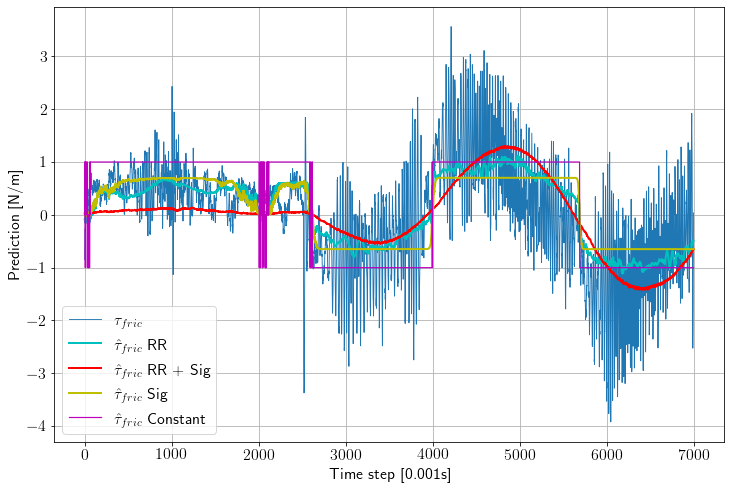

In [20]:
plt.figure(figsize=[12,8])
for channel in range(3,4):
#     plt.subplot(4,2,channel+1,xlabel="Time step [0.001s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.xlabel("Time step [0.001s]")
    plt.ylabel("Prediction [N/m]")
    plt.grid()
    plt.plot(Ytest[:7000,channel], label=r"$\tau_{fric}$", linewidth=0.9)
    plt.plot(pred_RR[:7000,channel], '-c', label=r"$\hat{\tau}_{fric}$ RR", linewidth=2)
    plt.plot(pred_BR[:7000,channel], '-r', label=r"$\hat{\tau}_{fric}$ RR + Sig", linewidth=2)
    plt.plot(pred_sig[:7000,channel], '-y', label=r"$\hat{\tau}_{fric}$ Sig", linewidth=2)
    plt.plot(pred_const[:7000,channel], '-m', label=r"$\hat{\tau}_{fric}$ Constant", linewidth=1.2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.16, hspace=0.12)
# plt.legend(bbox_to_anchor=(1.1, 0.8), fancybox=True)
plt.legend(fancybox=True)
plt.savefig('/home/jiayun/Desktop/residual.jpg', dpi=150)
plt.show()

In [13]:
# save parameters
Res = RR_l[0].beta.reshape(-1, 1)
for i in range(1,7):
    Res = np.concatenate([Res, RR_l[i].beta.reshape(-1, 1)], axis=1)
    
np.savetxt('Regression_weight/Tri_feature_decoupling.txt', Res)

In [14]:
from Common.utils import read_data, ButterWorthFilter, numerical_grad_nd
dataset = read_data('../data/test_trajectory/traj17_z.panda.dat')

time = dataset[:,0]

indx = max(np.where(time<38)[0])
time = time[:indx]
q_real = dataset[:indx,1:1+7]
q_ref = dataset[:indx,8:8+7]
qDot_real = dataset[:indx,15:15+7]
u_cmd = dataset[:indx, 22:22+7]
tau_real = dataset[:indx,29:29+7]
Gra = dataset[:indx,36:36+7]
u_G = u_cmd + Gra
G_dat = dataset[:indx,36:36+7]
C_dat = dataset[:indx, 43:43+7]
M_dat = dataset[:indx, 50:50+49]

qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)
qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.

In [15]:
M_aq = tau_real_filtered-G_dat-C_dat
res = []
for i in range(len(M_aq)):
    temp = np.linalg.inv(M_dat[i].reshape(7,7)) @ M_aq[i].reshape(7,1)
    res.append(temp.reshape(1,-1))
res = np.concatenate(res)

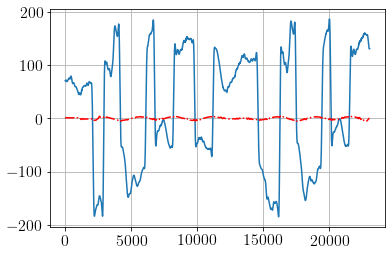

In [16]:
joint = 6
plt.plot(res[:,joint])
plt.plot(qDDot_inf[:,joint], '-.r')
# plt.plot(M_aq[:,joint])
# plt.plot(u_cmd[:,joint])
plt.grid()